<h3> Perturbation theory to approximate and infinite square well with a linear term V(x) = alpha x </h3>

In [ ]:
import math
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt


"""
Calculating the energy for any n without an added perturbation
n       = number of excited state
mass    = mass of particle in the well
length  = length of the well
"""
def unperturbed_energy(n, mass, length):
    numerator = math.pow(n,2) * math.pow(np.pi, 2) * math.pow(sc.hbar, 2)
    denominator = 2 * mass * math.pow(length, 2)

    return numerator / denominator

"""
Calculating the first order correction.
Found by solving ⟨1|V1|1⟩
This correction is generalized for all n, as it does not take n into account
"""
def first_order_correction(alpha, length):
    numerator = alpha * length

    return numerator / 2


"""
Calculating the second order correction for the ground state.
Found by solving:
        a^2 SUM(m=/=n) |⟨n|V1|n⟩|^2 / E(0)n - E(0)m
"""
def second_order_correction_groundstate(alpha, mass, length, max_n=10):
    # Split into left-hand-side (LHS) and right-hand-side(RHS) which is the sum over even n
    numerator = -128 * mass * (length**4) * (alpha**2)
    denominator = (np.pi**6) * (sc.hbar**2)
    prefactor = numerator / denominator

    # Now summing over even n
    sum_range = range(2,max_n, 2)
    sum_result = 0.0
    for n in sum_range:
        temp = (n**2) / (((n-1)**5) * ((n+1)**5))
        sum_result+=temp

    
    return prefactor * sum_result

""" 
Combining the unperturbed energy with the 2 corrections for our final result
"""
def energy_groundstate_second_order_perturbation(e01, e11, e21):
    return e01 + e11 + e21
    

6.024667394036591e-20
0.3760301621048726


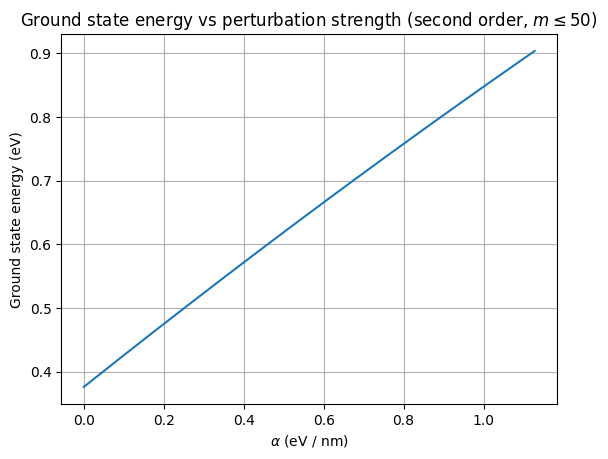

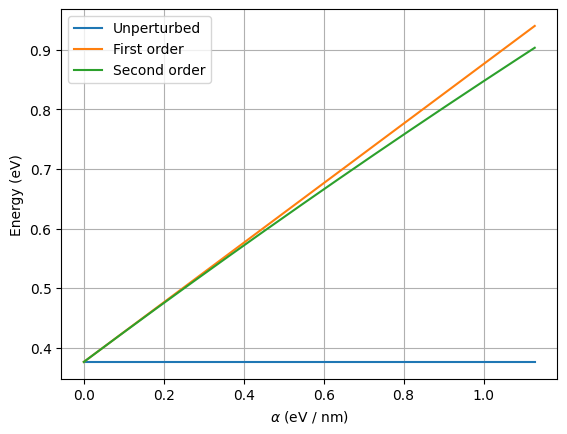

2 -0.0
4 -0.03660154283989046
6 -0.03664839281472551
10 -0.036650060286723525
20 -0.0366500913012612
50 -0.03665009147609415


In [12]:
particle_mass = sc.electron_mass # using an electron
well_length = 1e-9

ground_state = unperturbed_energy(1,particle_mass,well_length)
print(ground_state) # this is in joules
print(ground_state / sc.electron_volt) # this is in electron volts eV

""" 
We choose alpha such that the first-order perturbative correction becomes comparable to the unperturbed level spacing
"""
alpha_min = 0
delta_E = (3 * (np.pi**2) * (sc.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E / well_length
num_steps = 200
alpha_values = np.linspace(alpha_min, alpha_max, num_steps)

E0 = unperturbed_energy(1, particle_mass, well_length)

# list of ground state energies for different alphas
E_ground = []

for alpha in alpha_values:
    E1 = first_order_correction(alpha, well_length)
    E2 = second_order_correction_groundstate(
        alpha,
        particle_mass,
        well_length,
        max_n=50
    )
    E_ground.append(E0 + E1 + E2)

# Array of all ground-state energy levels in joules for range of alpha values
E_ground = np.array(E_ground)

# From joules to eV
E_ground_ev = E_ground / sc.electron_volt
alpha_ev_per_nm = alpha_values * well_length / sc.electron_volt

plt.figure()
plt.plot(alpha_ev_per_nm, E_ground_ev)
plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Ground state energy (eV)')
plt.title('Ground state energy vs perturbation strength (second order, $m \\leq 50$)')
plt.grid(True)
plt.show()


E_first_only = E0 + alpha_values * well_length / 2

plt.figure()
plt.plot(alpha_ev_per_nm, E0 / sc.electron_volt * np.ones_like(alpha_values))
plt.plot(alpha_ev_per_nm, E_first_only / sc.electron_volt)
plt.plot(alpha_ev_per_nm, E_ground_ev)

plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Energy (eV)')
plt.legend(['Unperturbed', 'First order', 'Second order'])
plt.grid(True)
plt.show()


for max_n in [2, 4, 6, 10, 20, 50]:
    E2 = second_order_correction_groundstate(alpha_max, particle_mass, well_length, max_n)
    print(max_n, E2 / sc.electron_volt)
